# CLML, Wine, PCA, K-Means and Hierarchical Clustering

> (C) 2015 Mike Maul -- CC-BY-SA 3.0

This document is part series of tutorials illustrating the use of CLML.

###Caveat
Anyone wishing to run this notebook or the code contained there in must take note of the following:
  - This tutorial relies on the github version of [`CLML` https://github.com/mmaul/clml.git](https://github.com/mmaul/clml.git) or a quicklist-dist `CLML`> than 20150805 
  - The plotting portion of this code requires the system [`clml.extras` https://github.com/mmaul/clml.extras.git](https://github.com/mmaul/clml.extras.git) which is not currently in quicklisp.
  - While the above git repositories are not in quicklisp they be loaded by `quickload` by placing the repositories in $HOME/quicklisp/local-projects

## Introduction
This article will discuss two clustering techniques, k-means and Hierarchical Clustering.
Clustering is an unsupervised learning technique, with the goa to group to samples into a given number of partitions.
Clustering uses uses the similarity between examples and groups examples based of their mutual similarities.

## Wine

Wine such a multideminensional beverage. A feast for the senses, taste, smell even for the eyes. It also pairs well with statistical analysis techniques and even Lisp. What does wine and statistical analysis have to do with one another you may ask. Well the Wine dataset at it the 'goto' dataset used in just about every introduction cluster analysis. The Wine dataset is a chemical analysis of three types of wines wines grown in a region of Italy. The dataset contains an analysis of 178 samples, with 13 results of chemical assays for each sample. It is small enough yet contains enough complexity to be interesting. The real value is that the dataset already contains the classification, so the lazy (er I mean pragmitic) presenters don't have to justify the classification, they only have to compare the results agains the esisting classifications. While were on the subject of wine if you find yourself in eastern Washington, I highly recommend stopping by the [Parisisos del Sol](www.paradisosdelsol.com) winery, good wine, down to earth atmosphere and a really interesting and knowledgeable propriter. 

But back to the cluster analysis stuff...

Lets get started by loading the system necessary for this tutorial and creating a namespace to work in.

In [1]:
(progn
    (ql:quickload '(:clml.utility ; Need clml.utility.data to get data from the net
                :clml.hjs ; Need clml.hjs.read-data to poke around the raw dataset
                :clml.pca
                :clml.clustering
                :iolib
                :clml.extras.eazy-gnuplot
                :eazy-gnuplot
                ))
    (defpackage #:wine
      (:use #:cl
        #:cl-jupyter-user
        #:clml.hjs.read-data
        #:clml.utility.data
        #:clml.hjs.vector
        #:clml.hjs.matrix
        #:clml.hjs.k-means
        #:clml.pca
        #:clml.clustering.hc
        #:eazy-gnuplot
        ))
)

To load "clml.utility":
  Load 1 ASDF system:
    clml.utility

; Loading "clml.utility"
....
To load "clml.hjs":
  Load 1 ASDF system:
    clml.hjs

; Loading "clml.hjs"

To load "clml.pca":
  Load 1 ASDF system:
    clml.pca

; Loading "clml.pca"

To load "clml.clustering":
  Load 1 ASDF system:
    clml.clustering

; Loading "clml.clustering"

To load "iolib":
  Load 1 ASDF system:
    iolib

; Loading "iolib"
.....
To load "clml.extras.eazy-gnuplot":
  Load 1 ASDF system:
    clml.extras.eazy-gnuplot

; Loading "clml.extras.eazy-gnuplot"

To load "eazy-gnuplot":
  Load 1 ASDF system:
    eazy-gnuplot

; Loading "eazy-gnuplot"



#<PACKAGE "WINE">

In [2]:
(in-package :wine)

#<PACKAGE "WINE">

##Take time to get to know your wine

This tutorial illistrates how to use clustering, as well as how to use Principal Componen Analysis in support of k-means and also hierarchical clustering in CLML. Just like swilling a bottle of wine is not a good thing neither is turning losse analysis techniques willy nilly on data. It is necessary to understand your data first, as the saying goes, garbage in garbage out...

Another take away from this tutorial is working with diverse data. Our dataset comes UCI Machine learning archive, the convention there is a headerless CSV file with seperate file ending in `.names` containing the a description of the dataset and the column names.

So armed with some information about the origin and meaning of the data, the orignization and the location we can begin.
The dataset is located at http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine

Well almost ready another thing that is necessary is to asses the data so we can ingest it properly. This is something that generally needs to be done manually or can be skipped with prior knowldege of the dataset. 

The `wine.names` file is rather verbose so We will just list the column names:
   1. Alcohol
   2. Malic acid
   3. Ash
   4. Alcalinity of ash  
   5. Magnesium
   6. Total phenols
   7. Flavanoids
   8. Nonflavanoid phenols
   9. Proanthocyanins
   10. Color intensity
   11. Hue
   12. OD280/OD315 of diluted wines
   13. Proline            

So lets take a peek at the data.

In [3]:
(defparameter uci-wine 
    (read-data-from-file
        (fetch "http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data")
        :type :csv))

UCI-WINE

In [4]:
(format nil "~A" (head-points uci-wine))

"#(#(1 13.2 1.78 2.14 11.2 100 2.65 2.76 .26 1.28 4.38 1.05 3.4 1050)
  #(1 13.16 2.36 2.67 18.6 101 2.8 3.24 .3 2.81 5.68 1.03 3.17 1185)
  #(1 14.37 1.95 2.5 16.8 113 3.85 3.49 .24 2.18 7.8 .86 3.45 1480)
  #(1 13.24 2.59 2.87 21 118 2.8 2.69 .39 1.82 4.32 1.04 2.93 735)
  #(1 14.2 1.76 2.45 15.2 112 3.27 3.39 .34 1.97 6.75 1.05 2.85 1450))"

So is is all numeric data, The first colum from the dataset definition is the class so we don't want to give that to our
clustering algorithim as that would be cheating. The numeric collumns should be of type double float

The k-means, and hierichal clustering implementationsrequires a numeric-dataset which we create by using `pick-and-specialize data`

In [5]:
(let ((wine-unspecialized (read-data-from-file
    (fetch "http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data")
    :type :csv
    :csv-type-spec '(integer
                     double-float double-float  double-float
                     double-float double-float  double-float
                     double-float double-float  double-float
                     double-float double-float  double-float
                     double-float)
    :csv-header-p ( list "Class"
                         "Alcohol"            "Malic acid"           "Ash"
                         "Alcalinity of ash"  "Magnesium"            "Total phenols"
                         "Flavanoids"         "Nonflavanoid phenols" "Proanthocyanins"
                         "Color intensity"    "Hue"                   "OD280/OD315 of diluted wines"
                         "Proline")
    )))
  (defparameter wine
    (pick-and-specialize-data 
       wine-unspecialized   
       :range '(1 2 3 4 5 6 7 8 9 10 11 12 13) :data-types (make-list 13 :initial-element :numeric )))
  (defparameter wine-with-classifications
    (pick-and-specialize-data 
       wine-unspecialized   
       :data-types (make-list 14 :initial-element :numeric )))

)

WINE-WITH-CLASSIFICATIONS

## Letting the wine breathe
The process of letting wine breathe is to exposure to the surrounding air. Letting allowing wine to mix and mingle with air and surrounding tempature. Similarly our data needs to "mix and mingle" so that the scales become more uniform which is helpful to clustering algorithims.

So we need to consider if the data needs to be standardized, generally the answer will be yes, unless the 
columns are all of the same units and have lov variance. Specifically with this datasets since the columns are using different units scaling is necessary. Our our implementation of `k-means` can do our standardization for us however we will need to do it for the principal component analysis.  The `standardize` function used here will be the z-score  which is $(c - \mu) / \sigma$.

## Savoring the wine
Savoring ths the process of detecting the essential properties generally using taste, we whiil however use principal component analysis instead. 

So what columns should be evaluated? We could evaluate all of them that might be okay, and would work in this case. However in the case of large datasets it may be necessary to reduce the dimensionality to decrease execution time. It could also be the case that some relatively unimportant columns could be throwing off the results.

#### Principal Component Analysis
Well one technique we can use to select the relevant columns for analysis is principal component analysis. Principal Component Analysis is a set of orthagonal transformations that reduce dimensionality in a dataset. One of the things that PCA can tell us is the mangnitute of the contribution of each column to the variation in the data. 

PCA is one of those algrorithims that needs regular data so we are going to standardize the dataset first. 

Lets compute a few things we will be needing.
  - `standardized-wine`: The stadardized copy of wine dataset
  - `pca-result`: The result of the PCA analysis of the standardized wine dataset

In [6]:
(progn 
  (defparameter standardized-wine (copy-dataset wine))
  (setf (dataset-numeric-points standardized-wine) (standardize (dataset-numeric-points standardized-wine)))
  
  (defparameter pca-result (princomp standardized-wine))
)

PCA-RESULT

One of the methods of evaluating the choice of principal components is the 'elbow' method. The elbow method involves choosing the number of components that lie in the elbow of the graph. In the graph below three or four would be a reasonable choice. 

Specifically `contributions` returns the variances of the components.

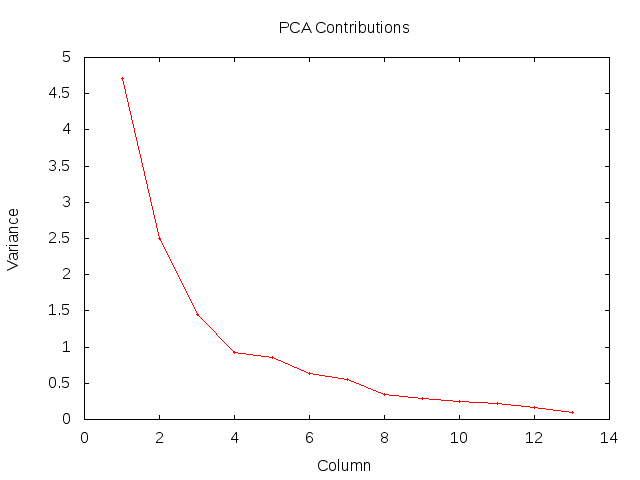

In [7]:
(let ((png "wine-pca-contributions.png"))
    (clml.extras.eazy-gnuplot::plot-series (contributions pca-result) 
    :term '(:png) :output png :plot-title "PCA Contributions" :ylabel "Variance" :xlabel "Column" :series-title "")
    (display-png (png-from-file png)))

One of the primary uses of PCA is to reduce dimensionality of data. In this case it allows us to make the decision that first four columns are what drive the majority of the variation in the data. So knowing this we will be truncating the data set to four columns. While this is not that critical in the current dataset which has only thirteen dimensions, it can be critical when dealing with datasets with hundreds or thousands of columns. 

So lets partition off the dataset so it only contains the principal columns, as we will need that later.

In [8]:
(defparameter truncated-standardized-wine (make-numeric-dataset  
                       (map 'list #'dimension-name (subseq (dataset-dimensions wine) 0 4))                           
                       (map 'vector (lambda (r) (subseq r 0 4)) (dataset-points standardized-wine))))

TRUNCATED-STANDARDIZED-WINE

## On to the wine tasting, a blind tasting
So for wine to be judged impartially it should be served without context and evaluated solely on its own merits. This is really what we are doing we already stripped the classifications from the dataset, and we aren't even tasting the wines ourselves. Out goal is to try match the wine varietal type with the preexisting classifications.

#### Deciding on the clusters
We need to have some idea of how the data will be grouped. In some cases this will be known, in others it will not. In this case we know theere are three different classifications.

But what if we didn't know? 

One method is to look at the within group of sums of squares among the contributions of the principal components of the dataset. We calculate the first value storing it in `wss1` the remaining values can be calulated by taking the sum of squares of the distances returned from running k-means (as the `distance-between-point-and-owner` slot in the `pca-result` instance returned from k-means)on the selected principal components from the previous PCA analysis.  

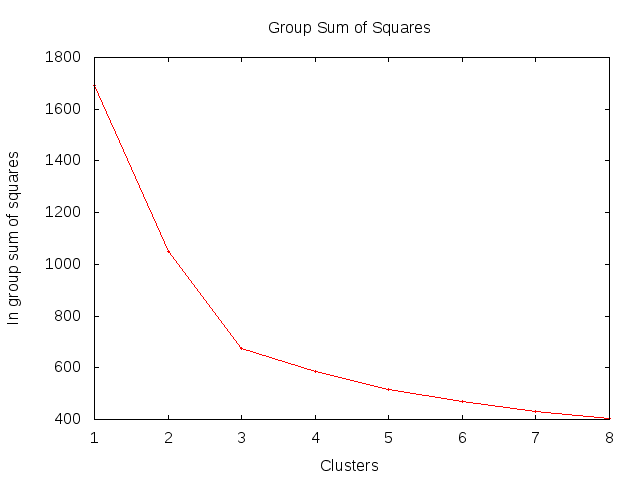

In [12]:
(let ((wss1 (* (- (length (components pca-result)) 1) 
               (loop for v across (subseq (contributions pca-result) 0 4) sum v)))
       (comp-ds (make-numeric-dataset '("pc1" "pc2" "pc3" "pc4")
                                      (map 'vector (lambda (r) (subseq r 0 4)) (components pca-result))))
        (png "group-sum-of-squares.png"))
    (clml.extras.eazy-gnuplot::plot-series 
      (coerce (cons wss1 
                  (loop for n from 2 upto 8 ; could be up size of dimensions the far end is generally irrelevant
                        for k-means-n = (k-means n comp-ds  :standardization nil 
                                                 :random-state (make-random-state-with-seed 100))
                        collect (loop for x across (clml.hjs.k-means::pw-distance-between-point-and-owner k-means-n) 
                                      sum (* x x)))) 
               'vector)
       :term '(:png) :output png :plot-title "Group Sum of Squares" :ylabel "In group sum of squares" 
       :xlabel "Clusters" :series-title "")
  
  (display-png (png-from-file png)))

Again we use the "elbow" method to make our selection (additionally in either selecting number of cluseter or the pricinpal components we can use the 85% precentile to make the choice point).

But what is really cool is the elbow lies right on three cluster which matches the number of clusters that had been manually classified in the wine dataset. 

#### K-means
So we kind of jumped into using `k-means` before talking about it...
Simplified description of the K-means Algorithm:

1. Initial cluster are randomly chosen.
2. The squared distance from each object to each cluster is computed, then the objects are assigned to the nearest cluster.
3. New centroid are computed for each cluster – and each cluster is  by the respective cluster centroid.
4. The squared distance from each object to each cluster is computed, and the objects are assigned to the cluster nearest cluster with the smallest squared distance.
5. Based upon the new membership assignement cluster centroids are recalculated.
6. Steps 4 and 5 are repeated until stability is achived.

The k in k-means is the number of clusters that k-means will be classifing. K is required parameter in k-means but how should we decide what to set it to?  Well we already know from the original dataset that there are three clusters.

So for testing or teaching you will want to set a fixed `:random-state` which will allow you have repeatable results (It influnces the choice of the seed clusters). 
But keep in mind if you set it all the time you might get caught on a local optima that you might have avoided if 
you had allowed the state to be random.

The CLML implementation of k-means accepts a number of parameters for running k-means.

* k-means arguments *
    - k:              <integer>, number of clusters
    - dataset:        <numeric-dataset> | <category-dataset> | <numeric-or-category-dataset>
    - distance-fn:    #'euclid-distance | #'manhattan-distance | #'cosine-distance
    - standardization:t | nil, whether to standardize the inputs
    - max-iteration:  maximum number of iterations of one trial (default 1000)
    - num-of-trials:  number of trials, every trial changes the initial position of the clusters. (Default 10)
    - random-state:   (for testing), specify the random-state of the random number generator
    - debug:          (for debugging) print out some debugging information

* k-means results *
    - workspacet: points, clusters, distance infomation, etc.
    - table:      lookup table for normalized vecs and original vecs, might be removed later.
    
Okay, so now that we know the number of clusters (well we've always known, but we also arrived at the same choice on our own), lets run k-means on our dataset.

In [10]:
 (progn  (defparameter workspace nil) 
         (defparameter table nil)
         (multiple-value-setq (workspace table)
           (k-means 3 truncated-standardized-wine  :standardization nil 
                    :random-state (make-random-state-with-seed 1234))))

#<CLML.HJS.K-MEANS::PROBLEM-WORKSPACE 3 Clusters (ID size): ((0 54) (1 62)
                                                             (2 62)) {1007736283}>

And we see out cluster assigment in the pretty print of the object. Lets compare roughly with the counts of the classification that came with the dataset. 


In [11]:
(loop for c across (!! wine-with-classifications "Class") 
  when (= c 1.0) count c into one when (= c 2.0) count c into two when (= c 3.0) count c into three 
  finally (return (list (list 1  one) (list 2 two) (list 3 three))))

((1 59) (2 71) (3 48))

So that doesn's look all that bad We can verify this in a bit.

One thing that hasn't been addressed is how to associate the classifications with the un-standardized data. Earlier we created a parameter `table` table contains a hash table that associates the standardized rows with their unstandardized rows.

#### Hierarchical Clustering

###### How it works

The clml imlementation of Hierarchical Clustering uses agglomerative clustering (bottom up approach)
A nice concise description of the processs of agglomerative clustering from [improvedoutcomes.com/](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Agglomerative_Hierarchical_Clustering_Overview.htm) is as follows:
  - Assign each object to a separate cluster.
  - Evaluate all pair-wise distances between clusters (distance metrics are described in Distance Metrics Overview).
  - Construct a distance matrix using the distance values.
  - Look for the pair of clusters with the shortest distance.
  - Remove the pair from the matrix and merge them.
  - Evaluate all distances from this new cluster to all other clusters, and update the matrix.
  - Repeat until the distance matrix is reduced to a single element.

The `distance-matrix`takes an optional argument `:distance-fn` which specifices the distance function used in the distance computations. The distance functions avalable are:
  - ecludian (Default)
  - manhattan
  - pearson
  - cosine
  - tanimoto
  - caberra

The `cophonetic-matric` function evaluates the distance matric and returns the merge and cophonetic matrix. The `cophonetic-matrix` take a optional `:method` parameter to specify the method used to evaulate the distance matrix. The evaluation methods are as follows.
  - `hc-single`
  - `hc-complete`
  - `hc-average` (default)
  - `hc-centroid`
  - `hc-median`
  - `hc-ward`

`cuttree` cuts the tree defined in the merge matrix into the specified number of pieces.


In [16]:
(progn
  (defparameter distance-matrix (distance-matrix (numeric-matrix standardized-wine)))
  (defparameter u nil) (defparameter v nil)
  (multiple-value-setq (u v) (cophenetic-matrix distance-matrix #'hc-ward))
  (defparameter ctree (cutree 3 v))
  (format t "Cut tree: ~A ~%Class counts:~A ~%" ctree
           (loop for x across ctree 
                 when (= x 1) counting x into one 
                 when (= x 2) counting x into two 
                 when (= x 3) counting x into three 
                 finally (return (list (list 1 one) (list 2 two) (list 3 three)))))
)

Cut tree: #(1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
            1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 2 2 3 3 3 1 3 3
            2 1 3 1 3 1 3 3 3 3 1 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 1 2 3 3 3 3 3
            3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 1 3 3 3 3 3 3 3 3 2 2 2 2 2 2
            2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
            2 2 2 2 2 2 2 2) 
Class counts:((1 65) (2 54) (3 59)) 


NIL

 

   (multiple-value-bind (workspace table)
           (k-means 3 wine  :standardization t :random-state state)
      ;;;; Now lets see how we did.
      (print workspace  )
      ;;;; #<CLML.HJS.K-MEANS::PROBLEM-WORKSPACE 3 Clusters (ID size):
      ;;;;   ((0 51) (1 61) (2 66)) {10097B0003}>
      ;;;; So the cluster distribution is ((0 51) (1 61) (2 66))
      ;;;; from the dataset description in the .names file the
      ;;;; actual distribution is: class 1 59
	  ;;;;                         class 2 71
	  ;;;;                         class 3 48
      ;;;; Not too bad
      ;;;; So what data is available from our clustering
      ;;;; The cluster centroids:
      (get-cluster-centroids workspace)
      ;;;; ((0
      ;;;;  . #(0.16444358896995892 0.8690954472537682 0.18637259499845618
      ;;;;      0.5228924410811502 -0.07526046614302336 -0.9765754839938489
      ;;;;      -1.2118292123465357 0.724021159373092 -0.7775131171790667
      ;;;;      0.9388902409225227 -1.1615121632678649 -1.2887761433394702
      ;;;;      -0.40594284143656034))
      ;;;;      
      ;;;;  (1
      ;;;;  . #(0.8756272418170851 -0.30371957168664576 0.3180446264140999
      ;;;;     -0.6626543948232362 0.5632992471916901 0.8740398997645874
      ;;;;      0.9409846247986108 -0.5839425807469174 0.5801464167356171
      ;;;;      0.1667181285145495 0.48236743459432646 0.7648958114081033
      ;;;;      1.1550887659006268))
      ;;;;  (2
      ;;;;  . #(-0.9363618907319501 -0.3908632414705565 -0.4379655235785164
      ;;;;      0.20840005437998074 -0.4624692470514986 -0.0531982454841447
      ;;;;      0.06671557146906414 -0.019766389431300546 0.06460965992817365
      ;;;;      -0.8795940625217612 0.45170767903647707 0.28892331536998617
      ;;;;      -0.753898936464753))
      ;;;;
      ;;;;  Cluster points
      (print (subseq (get-cluster-points workspace 0) 0 2))
      ;;;; #(#(1.3911617440421347 1.5787117630892988 1.361367967705916 1.4987155594909907
      ;;;;     -0.26196935775916486 -0.3916464788342626 -1.2707199546448487
      ;;;;     1.5921313718328312 -0.4208878242554346 1.78662613110848 -1.5200903793122311
      ;;;;     -1.4249282134945676 -0.5934862576893309)
      ;;;;   #(0.2086431208420219 0.22705327972312908 0.012696271660310293
      ;;;;     0.151234177571265 1.4184106667861087 -1.030776189881695 -1.350811364170554
      ;;;;     1.351077174906624 -0.22870070674327575 1.8297614498435204
      ;;;;     -1.5638403530401324 -1.396758819669375 0.2956638034293828))
      ;;;;

      )
   )
   (gethash (elt (get-cluster-points workspace 0) 0) table)


##Conclusion

The iPython notebook and source for this tutorial can be found in the [clml.tutorials https://github.com/mmaul/clml.tutorials.git](https://github.com/mmaul/clml.tutorials.git) github repository.

###Stay tuned to [clml.tutorials](https://mmaul.github.io/clml.tutorials/) blog or [RSS feed](https://mmaul.github.io/clml.tutorials/feed.xml) for more CLML tutorials..
